### Importing Libraries

In [1]:
from PIL import Image
import pandas as pd, numpy as np, time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import shap
import xgboost

### Loading the processed dataset 

In [2]:
df = pd.read_csv("./../data/email-messages-analysis.csv", encoding= 'unicode_escape')

In [3]:
df.shape

(5574, 157)

In [4]:
f"Missing values: {df.isna().sum().sum()}"

'Missing values: 0'

In [5]:
df.Email_Type.value_counts()

Email         4827
Spam Email     747
Name: Email_Type, dtype: int64

### Encoding the categorical features

In [6]:
le = LabelEncoder()
df["Email_Type"] = le.fit_transform(df["Email_Type"])
print(f"Email type: {le.classes_}")

df["Month"] = le.fit_transform(df["Month"])
print(f"Month: {le.classes_}")

df["Day_Period"] = le.fit_transform(df["Day_Period"])
print(f"Day Period: {le.classes_}")

Email type: ['Email' 'Spam Email']
Month: ['February' 'January' 'March']
Day Period: ['Afternoon' 'Evening' 'Morning' 'Night']


In [7]:
df.columns

Index(['Full_Text', 'got', 'great', 'wat', 'free', 'text', 'txt', 'win',
       'already', 'dun',
       ...
       'thing', 'many', 'wan', 'Common_Word_Count', 'Word_Count', 'Date',
       'Email_Type', 'Month', 'Day', 'Day_Period'],
      dtype='object', length=157)

### Defining the target for the classification and the features that are going to be used

In [8]:
y = df["Email_Type"]
X = df.drop(['Email_Type','Full_Text','Date'], axis=1)

Splitting the dataset into the training and testing subsets. 20% of the dataset were used for validating.

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
rfr = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
dtree = DecisionTreeClassifier()
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

estimators = [rfr, knn, dtree, xgb]
est_names = {0:'Random Forest Classifier',
             1:'K Nearest Neighbors Classifier',
             2:'Decision Tree Classifier',
             3:'XGBoost'}

def choose_best_estimator(Xtrain, ytrain, Xtest, ytest):

    print('Test Accuracy\n')
    scores = []
    for ind, est in enumerate(estimators):
        est.fit(Xtrain, ytrain)
        sc = est.score(Xtest, ytest)
        scores.append(sc)
        print("* %s: %.3f" % (est_names[ind], sc))    

    max_ind = scores.index(max(scores))
    print("\nBest accuracy: ", est_names[max_ind])

    return max_ind

In [11]:
best_est = choose_best_estimator(Xtrain, ytrain, Xtest, ytest)
ypred = estimators[best_est].predict(Xtest)
print(classification_report(ypred, ytest))

Test Accuracy

* Random Forest Classifier: 0.963
* K Nearest Neighbors Classifier: 0.891
* Decision Tree Classifier: 0.935
* XGBoost: 0.965

Best accuracy:  XGBoost
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       981
           1       0.82      0.91      0.86       134

    accuracy                           0.97      1115
   macro avg       0.90      0.94      0.92      1115
weighted avg       0.97      0.97      0.97      1115



In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for i, (train, test) in enumerate(cv.split(X, y)):
    model = estimators[best_est].fit(X.iloc[train], y[train])
    sc = model.score(X.iloc[test], y[test])
    scores.append(sc)
    #print(sc)
print(f"Mean: {np.mean(scores)}")

Mean: 0.9668100248770237


### Feature Importance

In [13]:
fimportances = estimators[best_est].feature_importances_
sorted_fimportances = np.argsort(fimportances)[::-1]

In [14]:
best_features_index = sorted_fimportances[:10]
best_features = Xtrain.columns[best_features_index]
best_features_importances = fimportances[best_features_index]

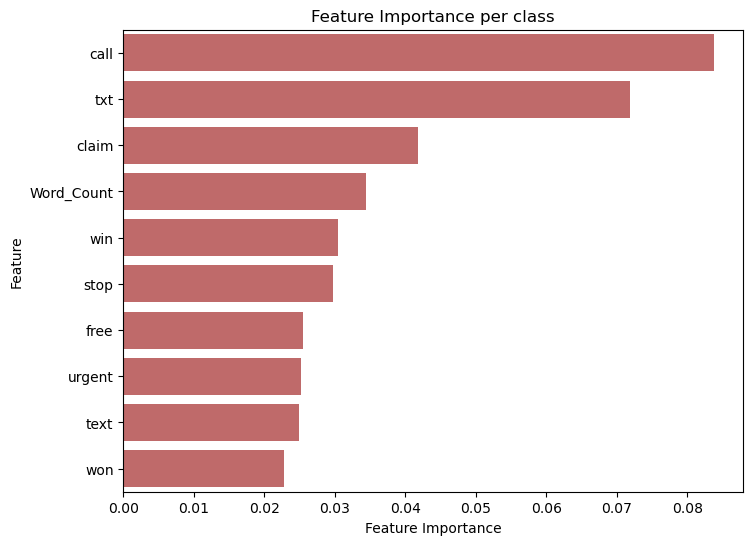

In [15]:
plt.figure(figsize=(8,6))
ax = sns.barplot(x=best_features_importances, y=best_features, color="indianred")
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Feature");
ax.set_title("Feature Importance per class")
plt.show()

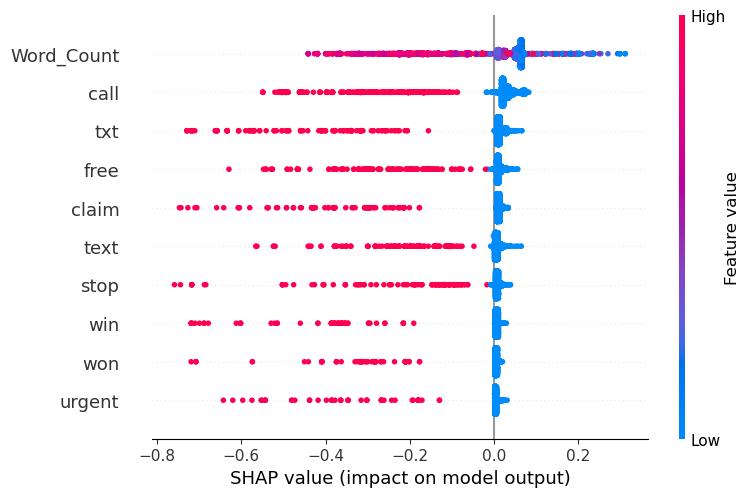

In [16]:
model = rfr.fit(Xtrain[best_features], ytrain)
explainer = shap.TreeExplainer(model)
shap_values = explainer(Xtrain[best_features])
shap.summary_plot(shap_values.values[:,:,0], Xtrain[best_features], max_display=30)

The more these words are used in a email message, the higher the chance of it being a spam email. 

### Applying PCA to dimensionality reduction

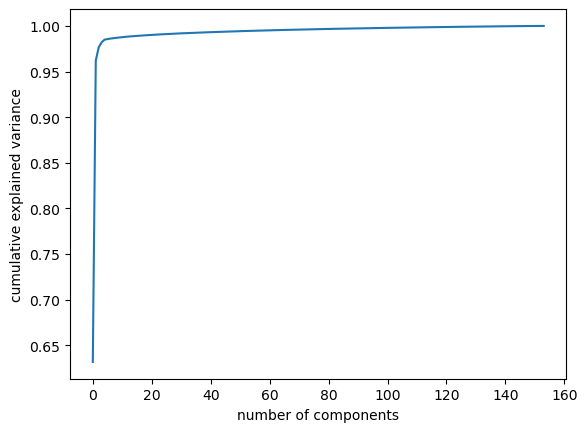

In [17]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [18]:
ncomp = 10
pca = PCA(n_components=ncomp)
pca.fit(X)
Xpca = pca.transform(X)

In [19]:
Xtrain_pca, Xtest_pca, ytrain_pca, ytest_pca = train_test_split(Xpca,y,test_size=0.2, stratify=y, random_state=42)
best_est = choose_best_estimator(Xtrain_pca, ytrain_pca, Xtest_pca, ytest_pca)
ypred = estimators[best_est].predict(Xtest_pca)
print(classification_report(ypred, ytest_pca))

Test Accuracy

* Random Forest Classifier: 0.952
* K Nearest Neighbors Classifier: 0.874
* Decision Tree Classifier: 0.935
* XGBoost: 0.949

Best accuracy:  Random Forest Classifier
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       993
           1       0.73      0.89      0.80       122

    accuracy                           0.95      1115
   macro avg       0.86      0.93      0.89      1115
weighted avg       0.96      0.95      0.95      1115



In [20]:
Xpca.shape

(5574, 10)